In [2]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
print(os.listdir('./flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


1 ) 導入各種模組。

In [72]:
# 忽略警告
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# 數據可視化和操作
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# 模型選擇
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 預處理
from collections.abc import Iterable

# dl圖書館
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# 專門用於cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import random as rn

# 專門用於操作zipped圖像並獲取圖像的像素值的numpy數組。
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

2 ) Preparing the Data
準備數據 

2.1) Making the functions to get the training and validation set from the Images
建立函數以從圖像中獲取訓練集和驗證集

In [42]:
test_Picture=[] # 用來暫時存放圖片
test_Feature=[] # 用來暫時存放標籤
Picture=[] # 用來存放圖片
Feature=[] # 用來存放標籤

# 目錄
DAISY_DIR='flowers/daisy' # 雛菊
SUNFLOWER_DIR='flowers/sunflower' # 向日葵
TULIP_DIR='flowers/tulip' # 鬱金香
DANDI_DIR='flowers/dandelion' # 蒲公英
ROSE_DIR='flowers/rose' # 玫瑰
ALL_DIR = [DAISY_DIR,SUNFLOWER_DIR,TULIP_DIR,DANDI_DIR,ROSE_DIR]

In [47]:
def assign_label(img,flower_type):
    return flower_type # 返回分類

In [48]:
def make_train_data(flower_type,DIR): # 定義一個函數，參數為花的類型和圖片的目錄
    for img in tqdm(os.listdir(DIR)): # 遍歷目錄中的每一個文件，tqdm是一個可以顯示進度條的庫
        label=flower_type # 調用assign_label函數為每個圖片分配標籤
        path = os.path.join(DIR,img) # 獲取每個圖片的完整路徑
        img = cv2.imread(path,cv2.IMREAD_COLOR) # 使用OpenCV讀取圖片，cv2.IMREAD_COLOR表示讀取彩色圖片
        img = cv2.resize(img, (150,150)) # 將圖片調整為指定的大小
        test_Picture.append(np.array(img)) # 將圖片數據添加到列表Picture中，將圖片數據轉換為numpy數組
        test_Feature.append(str(label)) # 將圖片的標籤添加到列表Feature中
        Picture.append(np.array(img)) # 將圖片數據添加到列表Picture中，將圖片數據轉換為numpy數組
        Feature.append(str(label)) # 將圖片的標籤添加到列表Feature中

In [75]:
count = 0
flowers = ['Daisy','Sunflower','Tulip','Dandelion','Rose']
for i in range(5):
    test_Picture = []
    make_train_data(flowers[i],ALL_DIR[i]) # 製作雛菊訓練數據
    print(f"{flowers[i]} count: {len(test_Picture)}\n")
    count = count + len(test_Picture)

print("\nAll Count: ",count)

100%|██████████| 764/764 [00:01<00:00, 675.99it/s]


Daisy count: 764



100%|██████████| 733/733 [00:01<00:00, 571.27it/s]


Sunflower count: 733



100%|██████████| 984/984 [00:01<00:00, 633.17it/s]


Tulip count: 984



100%|██████████| 1052/1052 [00:01<00:00, 651.56it/s]


Dandelion count: 1052



100%|██████████| 784/784 [00:01<00:00, 672.61it/s]

Rose count: 784


All Count:  4317


2.2 ) Visualizing some Random Images

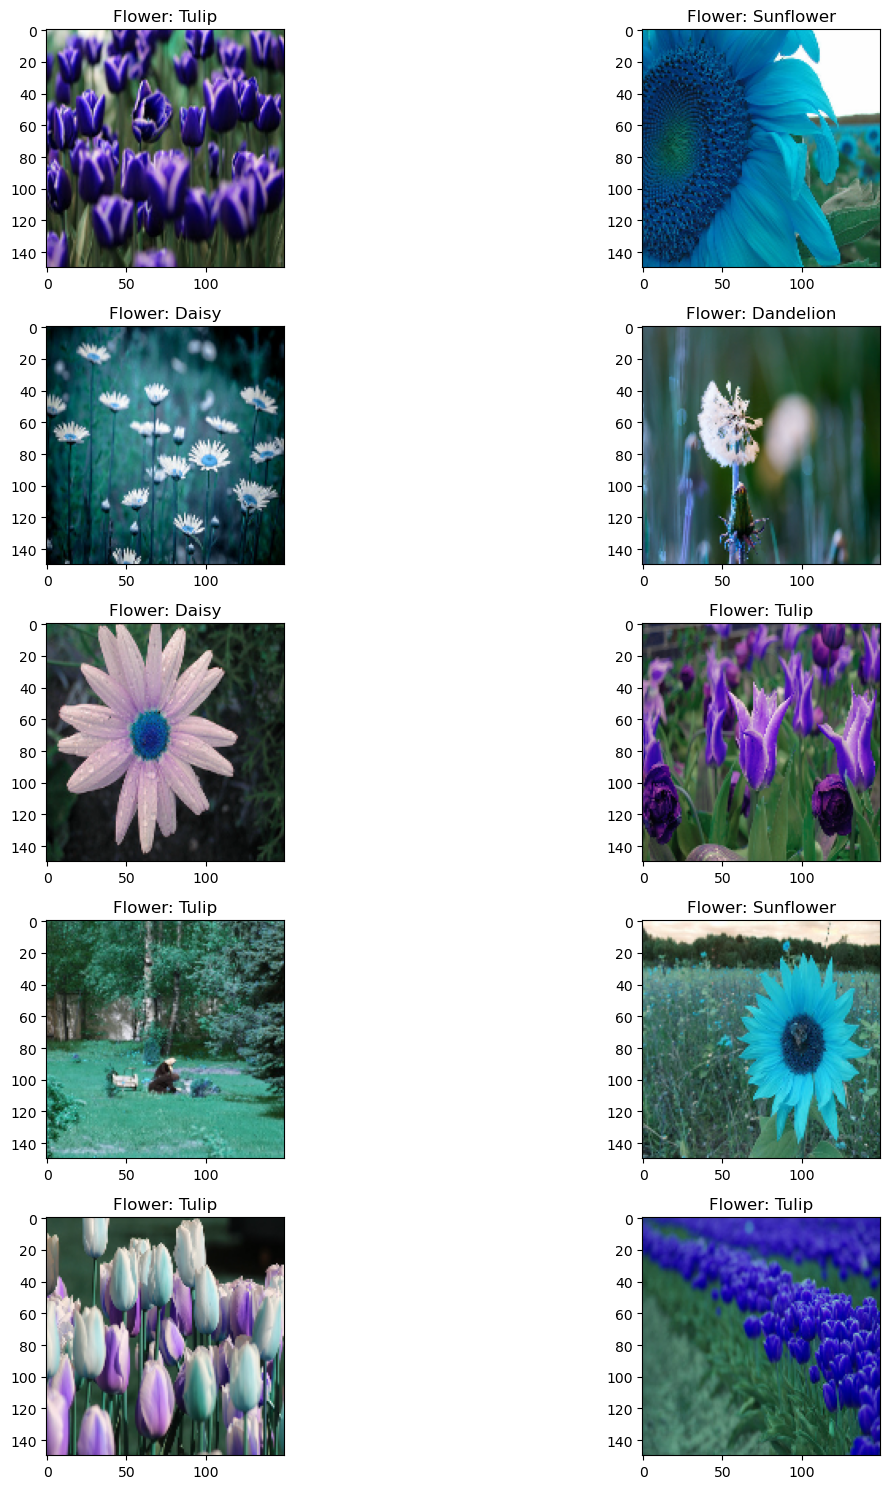

In [76]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        l = rn.randint(0, min(len(Picture), len(Feature))-1)  # 隨機數
        ax[i, j].imshow(Picture[l])  # 顯示圖片
        ax[i, j].set_title('Flower: ' + Feature[l])  # 顯示標題

plt.tight_layout() # 防止圖與圖之間重疊

2.3 ) 陣列進行標籤編碼（例如 Daisy->0, Rose->1等等）然後進行獨熱編碼(One Hot Encoding)。

In [77]:
le = LabelEncoder() # 將標籤轉換為數字的函式

Y = le.fit_transform(Feature) # 擬合跟特徵數據一樣
Y = to_categorical(Y,5) # 將Y轉為二進制矩陣

X = np.array(Picture) # 轉為numpy數組
# 由於圖片像素的顏色強度範圍通常是0到255，所以像素值除以255，這樣就可以將它們正規化到0到1的範圍
X = X/255 

2.4 ) 分割為訓練集和驗證集

In [78]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=20) # 訓練資料為75%，測試資料為25%

2.5 ) 設定隨機種子

In [79]:
# 為了確保實驗可以重現而設的種子值
np.random.seed(20)
rn.seed(20)
tf.random.set_seed(20)

3 ) Modelling建模

3.1 ) 用Keras建立卷積神經網路模型

In [104]:
# 使用Keras建立一個CNN

# Sequential模型是多個網路層的線性堆疊
model = Sequential()

# 添加第一個卷積層，32個5x5的卷積核，使用relu激活函數，輸入圖片大小為150x150，3個顏色通道
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2))) # 添加第一個池化層，池化層用於降低特徵維度，2x2的池化核，步長為2

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu')) # 添加第二個卷積層，64個3x3的卷積核，使用relu激活函數
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # 添加第二個池化層，2x2的池化核，步長為2

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu')) # 添加第三個卷積層，96個3x3的卷積核，使用relu激活函數
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # 添加第三個池化層，2x2的池化核，步長為2

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu')) # 添加第四個卷積層，96個3x3的卷積核，使用relu激活函數
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # 添加第四個池化層，2x2的池化核，步長為2

model.add(Flatten()) # 添加一個Flatten層，用於將多維輸入一維化，為卷積層到全連接層的過渡

model.add(Dense(512)) # 添加一個全連接層，有512個輸出節點

model.add(Activation('relu')) # 添加一個激活層，使用relu激活函數

# 添加一個輸出層，有5個輸出節點，對應5種分類，使用softmax激活函數，使輸出符合概率分佈
model.add(Dense(5, activation = "softmax"))

3.2 ) 使用學習率衰減LR Annealer（Learning Rate Annealer）

In [83]:
# 在每次訓練迭代中模型會同時處理128個訓練樣本。
batch_size=128

# 模型將會在整個訓練數據集上進行50次迭代(epoch)，每一次迭代都包括一次前向傳播和一次反向傳播。
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc', # 表示回調函數會監控驗證準確率
                          patience=3, # 如果驗證準確率在3個epoch內沒有提升，則學習率將會被降低
                          verbose=1, # 學習率被降低時，會在控制台輸出一條消息
                          factor=0.1) # 當學習率被降低時，新的學習率將會是原來學習率的0.1倍

3.3 ) 使用數據增強(Data Augmentation)以防止過度擬合

In [84]:
# 創建一個Keras裡ImageDataGenerator實例，並設定數據增強的參數
datagen = ImageDataGenerator(
    featurewise_center=False,  # 不將輸入數據的均值設為0
    samplewise_center=False,  # 不將每個樣本的均值設為0
    featurewise_std_normalization=False,  # 不將輸入數據除以數據集的標準差
    samplewise_std_normalization=False,  # 不將每個樣本除以其標準差
    zca_whitening=False,  # 不應用ZCA白化
    rotation_range=10,  # 隨機旋轉圖像的角度範圍為0到10度
    zoom_range = 0.1,  # 隨機縮放圖像的範圍為10%
    width_shift_range=0.2,  # 隨機水平移動圖像的範圍為總寬度的20%
    height_shift_range=0.2,  # 隨機垂直移動圖像的範圍為總高度的20%
    horizontal_flip=True,  # 隨機水平翻轉圖像
    vertical_flip=False  # 不隨機垂直翻轉圖像
)

# 使用x_train數據來擬合ImageDataGenerator
datagen.fit(x_train)

3.4 ) 編譯Keras模型並顯示摘要

In [85]:
model.compile(optimizer=Adam(learning_rate=0.001), # 使用Adam優化器，學習率為0.001
              loss='categorical_crossentropy', # 使用交叉熵損失函數
              metrics=['accuracy']) #設定模型的評估指標為準確率

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 96)      

3.5 ) 在訓練集上進行擬合並在驗證集上進行預測

In [87]:
# 使用ImageDataGenerator的flow方法來創建一個Python生成器，會在每次被調用時生成一批增強的數據

# 然後使用fit_generator方法來訓練模型
# 與fit方法不同，fit_generator方法可以在訓練過程中使用Python生成器來提供數據，這樣可以在訓練過程中實時增強數據
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), # 每個epoch結束時，模型會在這些驗證數據上評估其性能
                              verbose = 1, # 訓練過程中會輸出詳細的日誌信息
                              steps_per_epoch=x_train.shape[0] // batch_size) #表示在每個epoch中，模型會看到的批次數量為訓練數據集的樣本數量除以批次大小

# 以下是用fit的打法
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))
# 與fit_generator不同，fit方法需要將所有的訓練數據一次性傳入，因此不適合於大數據集或需要實時數據增強的情況


Epoch 1/50
75/75 [==============================] - 113s 1s/step - loss: 1.2238 - accuracy: 0.4781 - val_loss: 0.9646 - val_accuracy: 0.6245
Epoch 2/50
75/75 [==============================] - 108s 1s/step - loss: 0.9578 - accuracy: 0.6241 - val_loss: 0.9070 - val_accuracy: 0.6442
Epoch 3/50
75/75 [==============================] - 106s 1s/step - loss: 0.8428 - accuracy: 0.6755 - val_loss: 0.8183 - val_accuracy: 0.6899
Epoch 4/50
75/75 [==============================] - 105s 1s/step - loss: 0.7827 - accuracy: 0.7006 - val_loss: 0.7161 - val_accuracy: 0.7335
Epoch 5/50
75/75 [==============================] - 106s 1s/step - loss: 0.7238 - accuracy: 0.7213 - val_loss: 0.6760 - val_accuracy: 0.7468
Epoch 6/50
75/75 [==============================] - 105s 1s/step - loss: 0.6888 - accuracy: 0.7376 - val_loss: 0.6189 - val_accuracy: 0.7715
Epoch 7/50
75/75 [==============================] - 104s 1s/step - loss: 0.6498 - accuracy: 0.7499 - val_loss: 0.5986 - val_accuracy: 0.7761
Epoch 8/50
75

4 ) Evaluating the Model Performance評估模型性能

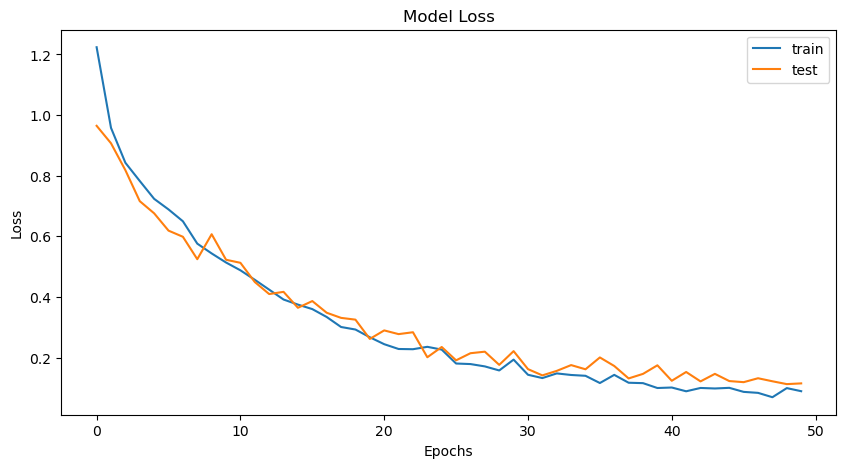

In [88]:
# 繪製模型的訓練損失和測試損失
plt.figure(figsize=(10, 5))
plt.plot(History.history['loss'])  # 繪製訓練損失
plt.plot(History.history['val_loss'])  # 繪製測試損失
plt.title('Model Loss')  # 設定圖表的標題
plt.ylabel('Loss')  # 設定 y 軸的標籤
plt.xlabel('Epochs')  # 設定 x 軸的標籤
plt.legend(['train', 'test'])  # 設定圖例，'train' 對應的是訓練損失，'test' 對應的是測試損失
plt.show()  # 顯示圖表

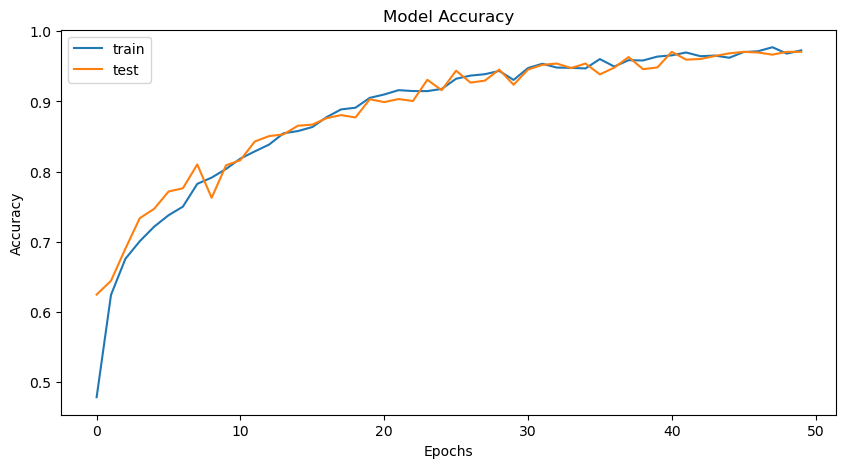

In [89]:
# 繪製模型的訓練準確率和測試準確率
plt.figure(figsize=(10, 5))
plt.plot(History.history['accuracy'])  # 繪製訓練準確率
plt.plot(History.history['val_accuracy'])  # 繪製測試準確率
plt.title('Model Accuracy')  # 設定圖表的標題
plt.ylabel('Accuracy')  # 設定 y 軸的標籤
plt.xlabel('Epochs')  # 設定 x 軸的標籤
plt.legend(['train', 'test'])  # 設定圖例，'train' 對應的是訓練準確率，'test' 對應的是測試準確率
plt.show()  # 顯示圖表

5 ) 可視化驗證集上的預測 

In [90]:
# 使用模型對測試集進行預測
pred=model.predict(x_test)

# 使用 np.argmax 找出每一行中最大概率即為此次預測分類
pred_digits=np.argmax(pred,axis=1)

102/102 [==============================] - 7s 71ms/step


In [91]:
prop_class = []  # 正確預測的樣本
mis_class = []  # 錯誤預測的樣本

i = 0
for i in range(len(y_test)):
    # 如果模型的預測結果與真實類別"相同"
    if np.argmax(y_test[i]) == pred_digits[i]:
        prop_class.append(i)
    # 如果已經找到了八個正確預測的樣本，則停止迴圈
    if len(prop_class) == 8:
        break

i = 0
for i in range(len(y_test)):
    # 如果模型的預測結果與真實類別"不同"
    if not np.argmax(y_test[i]) == pred_digits[i]:
        mis_class.append(i)
    # 如果已經找到了八個錯誤預測的樣本，則停止迴圈
    if len(mis_class) == 8:
        break

正確分類的花朵圖像

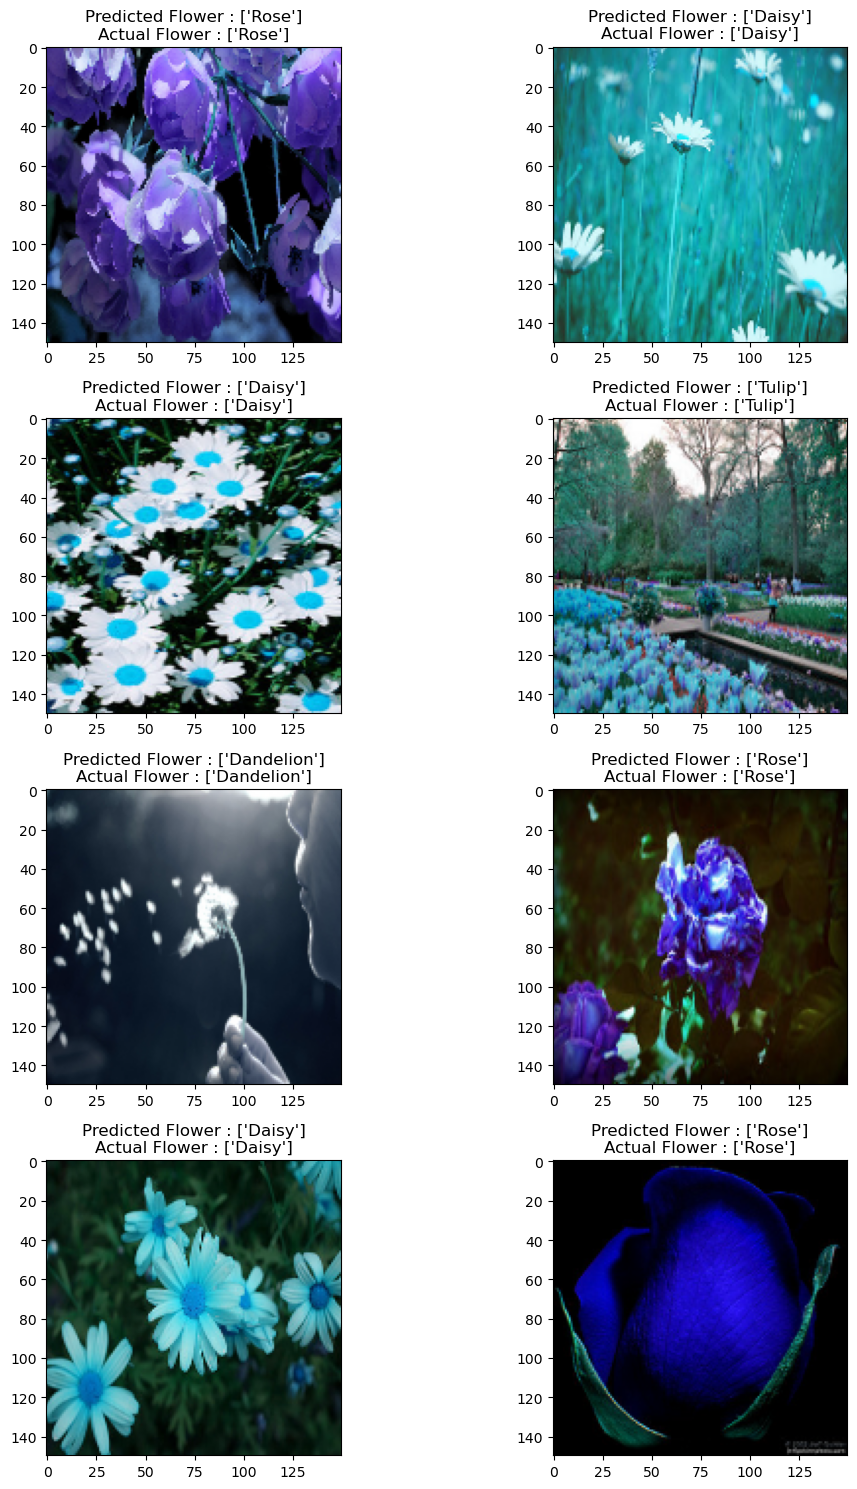

In [100]:
# 忽略所有警告
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0 # 初始化計數器

fig, ax = plt.subplots(4, 2) 
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]]) # 繪製模型正確預測的樣本的圖像

        # 設置標題，顯示模型的預測結果和真實類別
        # le.inverse_transform()將類別標籤轉換回原始的類別名稱 
        ax[i, j].set_title("Predicted Flower : " +
                           str(le.inverse_transform([pred_digits[prop_class[count]]]))#pred_digits[mis_class[count]] 是模型對錯誤預測的樣本的預測結果
                           + "\n" +
                           "Actual Flower : " +
                           str(le.inverse_transform([np.argmax(y_test[prop_class[count]])]))) #y_test[mis_class[count]]是錯誤預測的樣本的真實類別
        
        plt.tight_layout()# 調整子圖的佈局
        count += 1# 更新計數器

分類錯誤的花朵圖像

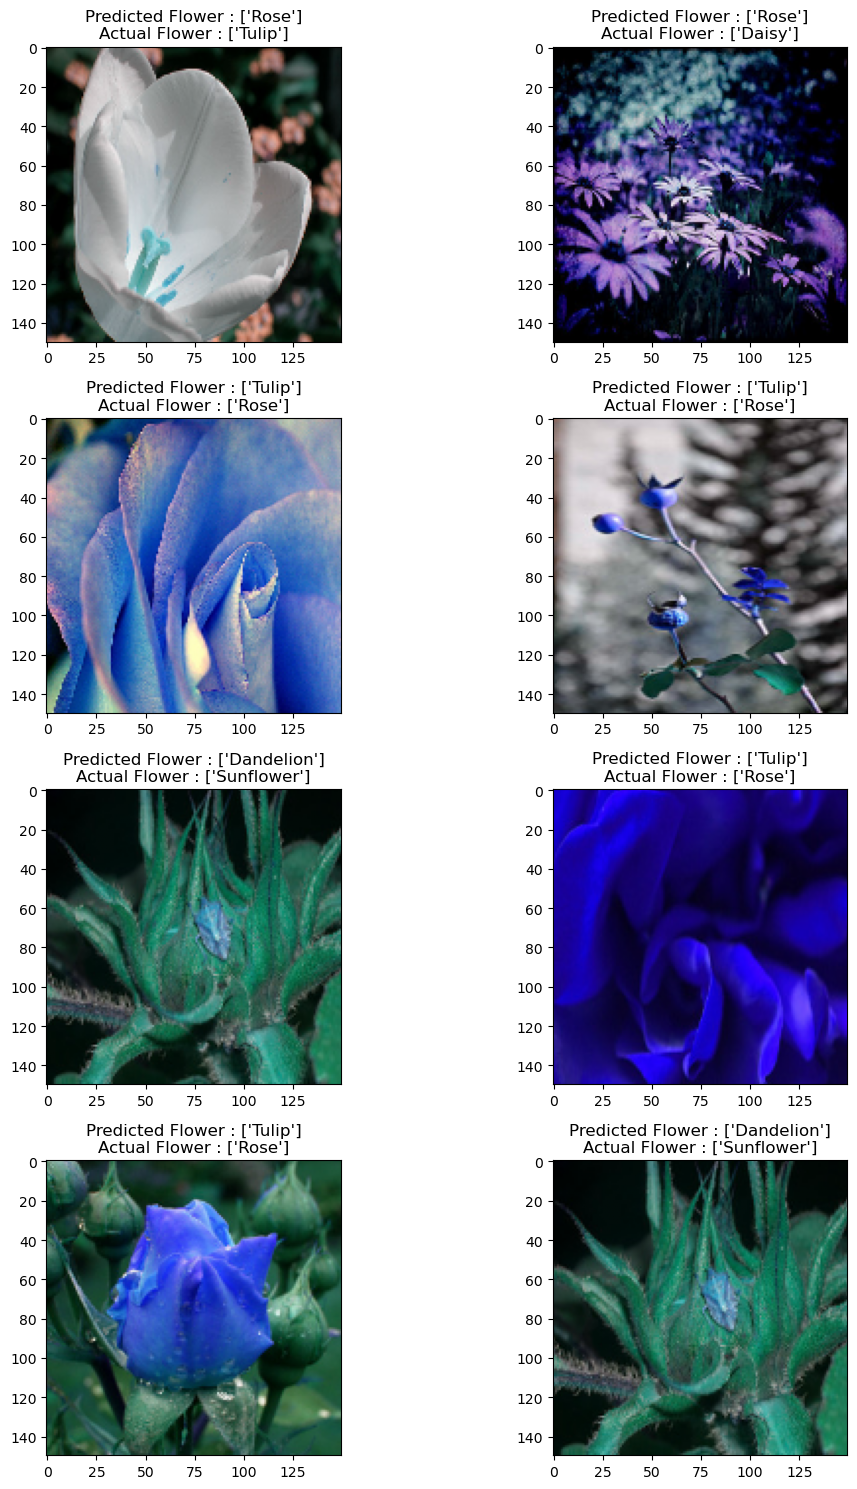

In [103]:
# 忽略所有警告
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0 # 初始化計數器

fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]]) # 繪製模型正確預測的樣本的圖像

        # 設置標題，顯示模型的預測結果和真實類別
        # le.inverse_transform()將類別標籤轉換回原始的類別名稱
        ax[i, j].set_title("Predicted Flower : " +
                           str(le.inverse_transform([pred_digits[mis_class[count]]]))#pred_digits[mis_class[count]] 是模型對錯誤預測的樣本的預測結果
                           + "\n" +
                           "Actual Flower : " +
                           str(le.inverse_transform([np.argmax(y_test[mis_class[count]])]))) #y_test[mis_class[count]]是錯誤預測的樣本的真實類別
        
        plt.tight_layout()# 調整子圖的佈局
        count += 1# 更新計數器

In [94]:
# 使用模型對測試集進行預測
predictions = model.predict(x_test)

# 將預測結果轉換為類別標籤
predicted_labels = np.argmax(predictions, axis=1)

# 將真實標籤轉換為類別標籤
y_true = np.argmax(y_test, axis=1)

# 計算每個類別的評估指標
report = classification_report(y_true, predicted_labels, target_names=flowers)

print(report)

102/102 [==============================] - 7s 70ms/step
              precision    recall  f1-score   support

       Daisy       0.99      0.96      0.98       577
   Sunflower       0.97      0.98      0.98       785
       Tulip       0.93      0.96      0.94       579
   Dandelion       0.99      0.98      0.98       540
        Rose       0.97      0.97      0.97       757

    accuracy                           0.97      3238
   macro avg       0.97      0.97      0.97      3238
weighted avg       0.97      0.97      0.97      3238

